«Мегалайн» — федеральный оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats as st
import math

In [105]:
calls = pd.read_csv('/datasets/calls.csv')
calls.name = 'calls'
internet = pd.read_csv('/datasets/internet.csv')
internet.name = 'internet'
messages = pd.read_csv('/datasets/messages.csv')
messages.name = 'messages'
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.name = 'tariffs'
users = pd.read_csv('/datasets/users.csv')
users.name = 'users'

## Изучение и предобработка данных

### calls

In [106]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [107]:
calls['call_date'] = pd.to_datetime(calls['call_date'])

In [108]:
calls['call_date'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

In [109]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

In [110]:
calls[calls['duration'] == 0 ]['duration'].count()

39613

<AxesSubplot:>

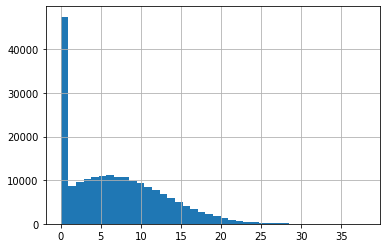

In [111]:
calls['duration'].hist(bins=40)

Самый продолжительный разговор длился 38 мин - в принципе ничего сверхестественного. Много нулевых значений в duration, но так наверно фиксируются "недозвоны", я думаю они тут не помешают.

In [112]:
calls.sample(5)

,id,call_date,duration,user_id
48504,1121_161,2018-08-20,0.00,1121
174194,1430_243,2018-06-23,11.37,1430
78883,1196_1115,2018-06-30,7.69,1196
73842,1185_636,2018-08-09,7.01,1185
128795,1330_659,2018-03-27,5.61,1330


In [113]:
calls.duplicated().value_counts()

False    202607
dtype: int64

### internet

In [114]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [115]:
internet.sample(5)

,Unnamed: 0,id,mb_used,session_date,user_id
119930,119930,1404_25,93.76,2018-12-07,1404
110989,110989,1376_249,413.40,2018-07-22,1376
11818,11818,1041_40,0.00,2018-11-30,1041
84436,84436,1286_118,336.74,2018-12-27,1286
3907,3907,1012_180,0.00,2018-04-29,1012


колонка "Unnamed: 0" дублирует индексы - удалю её

In [116]:
internet.pop('Unnamed: 0')

0              0
1              1
2              2
3              3
4              4
           ...  
149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, Length: 149396, dtype: int64

In [117]:
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [118]:
internet.duplicated().value_counts()

False    149396
dtype: int64

### messages

In [119]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [120]:
messages.sample(5)

,id,message_date,user_id
31999,1144_138,2018-12-02,1144
25291,1104_483,2018-08-16,1104
76545,1324_228,2018-11-05,1324
86051,1356_1068,2018-11-28,1356
109577,1440_518,2018-08-12,1440


In [121]:
messages['message_date'] = pd.to_datetime(messages['message_date'])

In [122]:
messages.duplicated().value_counts()

False    123036
dtype: int64

### tariffs

In [123]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [124]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### users

In [125]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [126]:
users['reg_date'] = pd.to_datetime(users['reg_date'])

<AxesSubplot:>

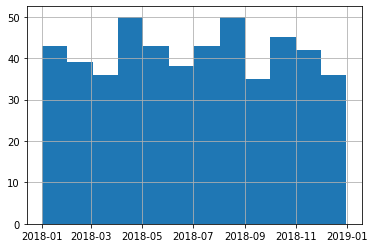

In [127]:
users['reg_date'].hist(bins=12)

Пользователи в данной выборке становились клиентами опретора постепенно - по 35-50 регистраций в месяц.

In [128]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [129]:
users.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
148,1148,23,NaN,Тольятти,Евдокия,Киреева,2018-04-17,ultra
260,1260,56,NaN,Москва,Афанасий,Горбунов,2018-07-16,smart
269,1269,31,NaN,Омск,Аким,Ахмадулин,2018-07-17,smart
106,1106,67,NaN,Калуга,Исаак,Костин,2018-04-26,ultra
210,1210,33,NaN,Севастополь,Евфросинья,Серебрякова,2018-07-29,smart


In [130]:
users.duplicated().value_counts()

False    500
dtype: int64

<b>Вывод</b>

Даннные хорошего качества, пропусков практически нет, дубликатов тоже, ошибок в данных также не наблюдаю, имена колонок оптимальные. Поправил только тип данных с датами. В остальном с этим можно работать.

In [164]:
def pre_info(data):
    print('\n','Информация о таблице',data.name,'\n')
    return display(data.info(),data.head(5),data.describe())
    
list_data = [calls,internet,messages,tariffs,users]

for item in list_data:
    pre_info(item)


 Информация о таблице calls 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             202607 non-null  object        
 1   call_date      202607 non-null  datetime64[ns]
 2   duration       202607 non-null  float64       
 3   user_id        202607 non-null  int64         
 4   call_month     202607 non-null  period[M]     
 5   tariff_minuts  202607 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1), period[M](1)
memory usage: 9.3+ MB


None

,id,call_date,duration,user_id,call_month,tariff_minuts
0,1000_0,2018-07-25,0.00,1000,2018-07,0.0
1,1000_1,2018-08-17,0.00,1000,2018-08,0.0
2,1000_2,2018-06-11,2.85,1000,2018-06,3.0
3,1000_3,2018-09-21,13.80,1000,2018-09,14.0
4,1000_4,2018-12-15,5.18,1000,2018-12,6.0


,duration,user_id,tariff_minuts
count,202607.000000,202607.000000,202607.000000
mean,6.755887,1253.940619,7.158198
std,5.843365,144.722751,5.959173
min,0.000000,1000.000000,0.000000
25%,1.300000,1126.000000,2.000000
50%,6.000000,1260.000000,6.000000
75%,10.700000,1379.000000,11.000000
max,38.000000,1499.000000,38.000000



 Информация о таблице internet 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
 4   month         149396 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int64(1), object(1), period[M](1)
memory usage: 5.7+ MB


None

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,2018-11
1,1000_1,1052.81,2018-09-07,1000,2018-09
2,1000_2,1197.26,2018-06-25,1000,2018-06
3,1000_3,550.27,2018-08-22,1000,2018-08
4,1000_4,302.56,2018-09-24,1000,2018-09


,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000



 Информация о таблице messages 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             123036 non-null  object        
 1   message_date   123036 non-null  datetime64[ns]
 2   user_id        123036 non-null  int64         
 3   message_month  123036 non-null  period[M]     
dtypes: datetime64[ns](1), int64(1), object(1), period[M](1)
memory usage: 3.8+ MB


None

,id,message_date,user_id,message_month
0,1000_0,2018-06-27,1000,2018-06
1,1000_1,2018-10-08,1000,2018-10
2,1000_2,2018-08-04,1000,2018-08
3,1000_3,2018-06-16,1000,2018-06
4,1000_4,2018-12-05,1000,2018-12


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000



 Информация о таблице tariffs 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000



 Информация о таблице users 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


## Расчёты и добавление результатов в таблицу

### количество сделанных звонков и израсходованных минут разговора по месяцам

Создам столбец с указанием только месяца совершенного вызова

In [165]:
# calls['call_month'] = calls['call_date'].dt.month

Создам столбец с количеством минут по тарифу - округление в большую сторону

In [166]:
calls['call_month'] = calls['call_date'].dt.to_period('M')

In [167]:
# calls['tariff_minuts'] = calls['duration'].apply(math.ceil)

In [168]:
calls['tariff_minuts'] = np.ceil(calls['duration'])

Сведу таблицу по пользователям и месяцам - количество состоявшихся разговоров и суммарное количество тариффицированных минут(округленных в большую сторону)

In [169]:
fdf = pd.pivot_table(data=calls[calls['duration'] != 0],index=['user_id','call_month'],values='tariff_minuts',aggfunc=['count','sum'])

переименую столбцы, сброшу мульти индексы

In [170]:
fdf.columns = list(map("_".join, fdf.columns))

In [171]:
fdf.reset_index(inplace=True)  
fdf = fdf.rename(columns={'call_month':'month','count_tariff_minuts':'calls_count'})

In [172]:
fdf.head()

,user_id,month,calls_count,sum_tariff_minuts
0,1000,2018-05,17,159.0
1,1000,2018-06,28,172.0
2,1000,2018-07,41,340.0
3,1000,2018-08,42,408.0
4,1000,2018-09,46,466.0


Скопирую таблицу в рабочий датасет - users_merge

In [173]:
users_merge = fdf.copy() 

###  количество отправленных сообщений по месяцам

делаем также как в предыдущем разделе

In [174]:
messages['message_month'] = messages['message_date'].dt.to_period('M')

In [175]:
fdf = pd.pivot_table(messages, index=['user_id','message_month'], values='id', aggfunc='count')

In [176]:
fdf.reset_index(inplace=True)

In [177]:
fdf = fdf.rename(columns={'id':'messages','message_month':'month'})

In [178]:
users_merge = pd.merge(users_merge,fdf,how='outer')

In [179]:
users_merge['messages'] = users_merge['messages'].fillna(0)  # у некоторых абонентов небыло сообщений за месяц - NAN заменяем на 0

Сольём данные в рабочую таблицу

In [180]:
users_merge.head()

,user_id,month,calls_count,sum_tariff_minuts,messages
0,1000,2018-05,17.0,159.0,22.0
1,1000,2018-06,28.0,172.0,60.0
2,1000,2018-07,41.0,340.0,75.0
3,1000,2018-08,42.0,408.0,81.0
4,1000,2018-09,46.0,466.0,57.0


###  объем израсходованного интернет-трафика по месяцам

In [181]:
# создадим колонку с месяцами
internet['month'] = internet['session_date'].dt.to_period('M')

In [182]:
# сведем в таблицу по месяцам
fdf = pd.pivot_table(internet, index=['user_id','month'], values='mb_used',aggfunc='sum')

In [183]:
fdf.reset_index(inplace=True)

In [184]:
fdf['gb_used'] = (fdf['mb_used']/1024).round(2) # переведём в гигабайты 

In [185]:
# создам колонку с тарифицируемыми гигабайтами
fdf['tariff_gb_used'] = np.ceil(fdf['gb_used'])

In [186]:
# солью в рабочий датасет
users_merge = pd.merge(users_merge, fdf, how='outer')

In [187]:
# заменю наны - у некоторых пользователей небыло трафика за месяц
users_merge[['mb_used','gb_used','tariff_gb_used']] = users_merge[['mb_used','gb_used','tariff_gb_used']].fillna(0)

Теперь удобно в таблице смотреть сколько абонент за месяц использовал гигабайт и за сколько гигабайт с него списали

### помесячная выручка с каждого пользователя 

Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножим на значение из тарифного плана, прибавим абонентскую плату, соответствующую тарифному плану.

In [188]:
users_merge = pd.merge(users_merge, users[['user_id','tariff']], on='user_id', how='outer')

In [189]:
users_merge[['calls_count','sum_tariff_minuts']] = users_merge[['calls_count','sum_tariff_minuts']].fillna(0)
users_merge

,user_id,month,calls_count,sum_tariff_minuts,messages,mb_used,gb_used,tariff_gb_used,tariff
0,1000,2018-05,17.0,159.0,22.0,2253.49,2.20,3.0,ultra
1,1000,2018-06,28.0,172.0,60.0,23233.77,22.69,23.0,ultra
2,1000,2018-07,41.0,340.0,75.0,14003.64,13.68,14.0,ultra
3,1000,2018-08,42.0,408.0,81.0,14055.93,13.73,14.0,ultra
4,1000,2018-09,46.0,466.0,57.0,14568.91,14.23,15.0,ultra
...,...,...,...,...,...,...,...,...,...
3211,1489,2018-10,0.0,0.0,21.0,19559.44,19.10,20.0,smart
3212,1489,2018-11,0.0,0.0,20.0,17491.56,17.08,18.0,smart
3213,1489,2018-12,0.0,0.0,35.0,17322.51,16.92,17.0,smart
3214,1128,NaT,0.0,0.0,NaN,NaN,NaN,NaN,ultra


In [190]:
users_merge.shape

(3216, 9)

In [191]:
users_merge.user_id.nunique()

500

In [192]:
# функция для расчета выручки с абонента за месяц.
def get_revenue(user_id, sum_tariff_minuts, messages, mb_used, tariff):
    tariff_info = tariffs[tariffs['tariff_name'] == tariff]        # получаем инфу из тарифного плана абонента
    minutes_included = tariff_info['minutes_included'].values[0]   # далее присваеваем в переменные значения из тарифного плана 
    messages_included = tariff_info['messages_included'].values[0]
    mb_per_month_included = tariff_info['mb_per_month_included'].values[0]
    rub_per_minute   = tariff_info['rub_per_minute'].values[0]     
    rub_per_message  = tariff_info['rub_per_message'].values[0] 
    rub_per_gb = tariff_info['rub_per_gb'].values[0]
    rub_monthly_fee = tariff_info['rub_monthly_fee'].values[0]
   
    # по формуле расчитываем выручку
    revenue = max(sum_tariff_minuts - minutes_included, 0 ) * rub_per_minute + \
              max(messages - messages_included, 0) * rub_per_message + \
              np.ceil( max(mb_used - mb_per_month_included, 0) / 1024) * rub_per_gb + \
              rub_monthly_fee
    return revenue


# создаём колокнку для выручки ,         для каждой строки вызывая функцию get_revenue и передовая в неё параметры
users_merge['revenue'] = users_merge.apply(lambda row: get_revenue(row['user_id'],
                                                                   row['sum_tariff_minuts'],
                                                                   row['messages'],
                                                                   row['mb_used'],
                                                                   row['tariff']
                                                                  ), 
                                                                   axis = 1)

In [193]:
users_merge['revenue'].describe()

count    3212.000000
mean     1528.814134
std       798.430503
min       550.000000
25%       750.000000
50%      1651.500000
75%      1950.000000
max      6770.000000
Name: revenue, dtype: float64

In [200]:
users_merge = users_merge.sort_values('user_id')
users_merge.tail(10)

,user_id,month,calls_count,sum_tariff_minuts,messages,mb_used,gb_used,tariff_gb_used,tariff,revenue
3165,1497,2018-10,50.0,490.0,20.0,11500.29,11.23,12.0,smart,550.0
3167,1497,2018-12,58.0,545.0,17.0,19918.60,19.45,20.0,smart,1685.0
3171,1498,2018-10,30.0,247.0,42.0,20579.36,20.10,21.0,smart,1750.0
3170,1498,2018-09,53.0,471.0,44.0,22134.41,21.62,22.0,smart,1950.0
3169,1498,2018-08,43.0,400.0,62.0,24235.21,23.67,24.0,smart,2386.0
3168,1498,2018-07,20.0,175.0,20.0,7476.24,7.30,8.0,smart,550.0
3174,1499,2018-11,62.0,612.0,59.0,17963.31,17.54,18.0,smart,1513.0
3175,1499,2018-12,56.0,492.0,66.0,13055.58,12.75,13.0,smart,598.0
3172,1499,2018-09,8.0,70.0,11.0,1845.75,1.80,2.0,smart,550.0
3173,1499,2018-10,44.0,449.0,48.0,17788.51,17.37,18.0,smart,1150.0


Теперь мы видим на сколько абонент "наговорил" в месяц

In [201]:
users_merge.user_id.nunique()

498

почищу пару строк с нулевыми значениями - они будут нам бесполезны

In [202]:
users_merge[users_merge['month'] == 0]

,user_id,month,calls_count,sum_tariff_minuts,messages,mb_used,gb_used,tariff_gb_used,tariff,revenue


In [203]:
#users_merge = users_merge.drop(labels = [827,2335],axis = 0)
users_merge = users_merge.query('user_id not in [1128,1371]')

## Анализ данных

Опишем поведение клиентов оператора, представленных в выборке. Посмотрим сколько минут разговора,сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. <br>
Можно взять средне месяцные значения группированные по пользователям, но я думаю всё же лучше смотреть просто по месяцные данные не группируя по пользователям.

### Минуты

In [204]:
def var1(x):
    return np.var(x, ddof=1)

pd.pivot_table(users_merge, index='tariff', values='sum_tariff_minuts', aggfunc=['mean', var1, np.std]).round(2).T

,tariff,smart,ultra
mean,sum_tariff_minuts,417.93,526.62
var1,sum_tariff_minuts,36219.32,100873.63
std,sum_tariff_minuts,190.31,317.61


In [205]:
pd.pivot_table(users_merge, index='tariff', values='sum_tariff_minuts', aggfunc=['mean', var1, np.std]).round(2).T

,tariff,smart,ultra
mean,sum_tariff_minuts,417.93,526.62
var1,sum_tariff_minuts,36219.32,100873.63
std,sum_tariff_minuts,190.31,317.61


/home/jovyan/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jovyan/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


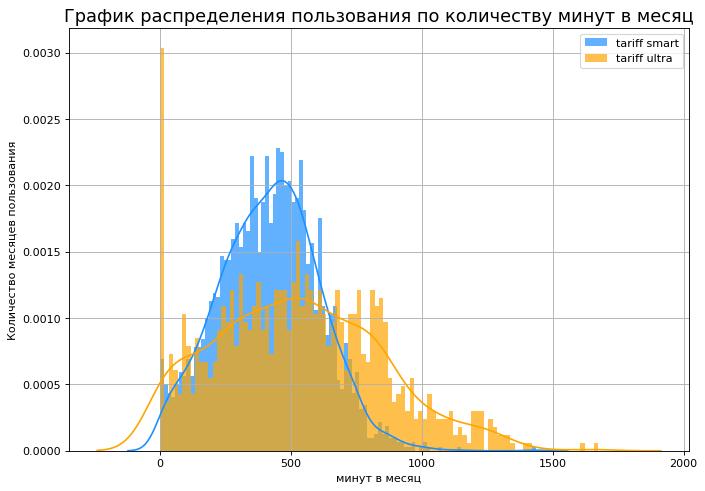

In [206]:
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(users_merge.loc[users_merge['tariff'] == 'smart', "sum_tariff_minuts"], 
             color="dodgerblue", 
             label="tariff smart", 
             hist_kws={'alpha':.7}, bins=100) 

sns.distplot(users_merge.loc[users_merge['tariff'] == 'ultra', "sum_tariff_minuts"], 
             color="orange", 
             label="tariff ultra", 
             hist_kws={'alpha':.7}, bins=100)

plt.title('График распределения пользования по количеству минут в месяц', fontsize=16)
plt.xlabel('минут в месяц')
plt.ylabel('Количество месяцев пользования')
plt.legend()
plt.grid(True)
plt.show()

Из гистрограммы видно на тарифе Smart люди не убираются в лимит 500 минут и часто выходят за него.

А вот так выглядит график группированный по пользователям - тренды конечно сохраняются , но распределение не такое ровное, поэтому группировать далее не буду.

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Здорово, когда график и его оси подписаны 😊👍
    
Так быстрее понять о чем идёт речь на самом графике.
    
</div>

/home/jovyan/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jovyan/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


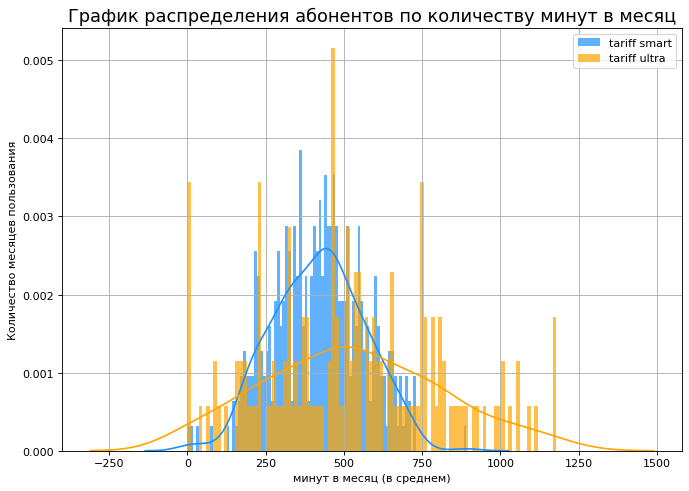

In [207]:
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(users_merge.loc[users_merge['tariff'] == 'smart'].groupby('user_id')["sum_tariff_minuts"].mean(), 
             color="dodgerblue", 
             label="tariff smart", 
             hist_kws={'alpha':.7}, bins=100) 

sns.distplot(users_merge.loc[users_merge['tariff'] == 'ultra'].groupby('user_id')["sum_tariff_minuts"].mean(), 
             color="orange", 
             label="tariff ultra", 
             hist_kws={'alpha':.7}, bins=100)

plt.title('График распределения абонентов по количеству минут в месяц', fontsize=16)
plt.xlabel('минут в месяц (в среднем)')
plt.ylabel('Количество месяцев пользования')
plt.legend()
plt.grid(True)
plt.show()

In [208]:
def show_me_comparison(data1, data2, title):
    plt.figure(figsize=(10,7), dpi= 80)
    
    sns.displot(data1, kind='hist',color="dodgerblue",alpha=0.7 ,
             label="tariff smart", 
             bins=50)
    
    sns.displot(data2, kind='hist',color="orange", alpha=0.7 ,
             label="tariff ultra", 
             bins=50)   
    
    plt.title(title, fontsize=16)
    plt.xlabel('минут в месяц (в среднем)')
    plt.ylabel('Количество месяцев пользования')
    plt.legend()
    plt.grid(True)
    

<Figure size 800x560 with 0 Axes>

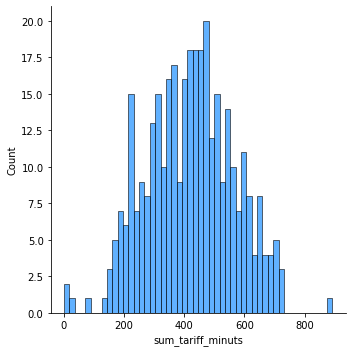

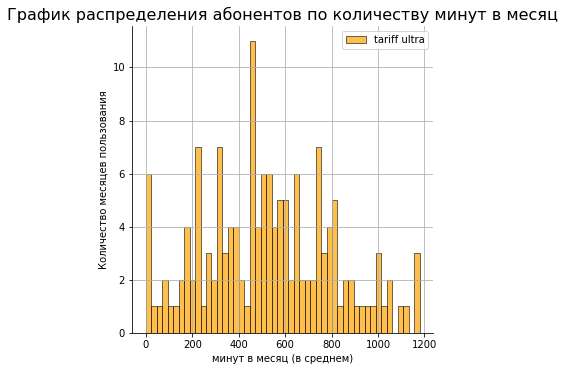

In [209]:
df1 = users_merge.loc[users_merge['tariff'] == 'smart'].groupby('user_id')["sum_tariff_minuts"].mean()
df2 = users_merge.loc[users_merge['tariff'] == 'ultra'].groupby('user_id')["sum_tariff_minuts"].mean()

show_me_comparison(df1, df2, 'График распределения абонентов по количеству минут в месяц')

plt.show()

### Сообшения

In [210]:
pd.pivot_table(users_merge, index='tariff', values='messages', aggfunc=['mean', var1, np.std]).round(2)

,mean,var1,std
,messages,messages,messages
tariff,,,
smart,33.38,796.81,28.23
ultra,49.46,2284.95,47.80


/home/jovyan/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jovyan/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


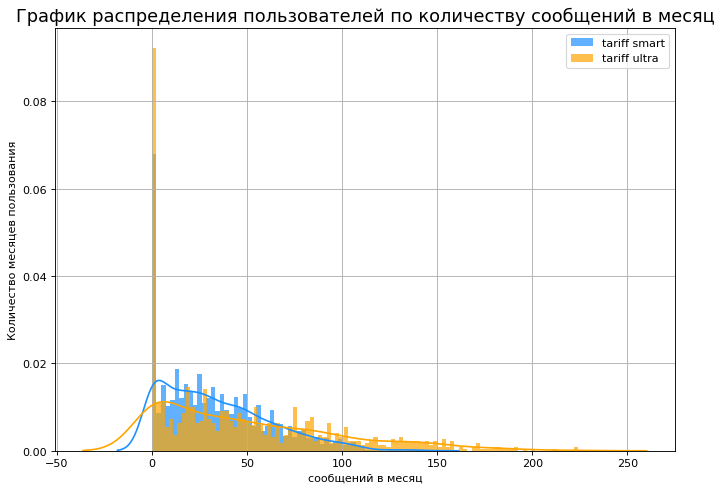

In [211]:
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(users_merge.loc[users_merge['tariff'] == 'smart', "messages"], 
             color="dodgerblue", 
             label="tariff smart", 
             hist_kws={'alpha':.7}, bins=60) 

sns.distplot(users_merge.loc[users_merge['tariff'] == 'ultra', "messages"], 
             color="orange", 
             label="tariff ultra", 
             hist_kws={'alpha':.7}, bins=100)

plt.title('График распределения пользователей по количеству сообщений в месяц', fontsize=16)
plt.xlabel('сообщений в месяц')
plt.ylabel('Количество месяцев пользования')
plt.legend()
plt.grid(True)
plt.show()

Видим что очень часто не отправляют ни одной смс за месяц. На тарифе Smart перерасход лимитных смс.

### Интернет трафик

Посмотрим сколько трафика в среднем в месяц используют пользователи на различных тарифах

In [212]:
pd.pivot_table(users_merge, index='tariff', values='mb_used', aggfunc=['mean', var1, np.std]).round(2)

,mean,var1,std
,mb_used,mb_used,mb_used
tariff,,,
smart,16208.39,3.446250e+07,5870.48
ultra,19468.81,1.017510e+08,10087.17


/home/jovyan/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jovyan/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


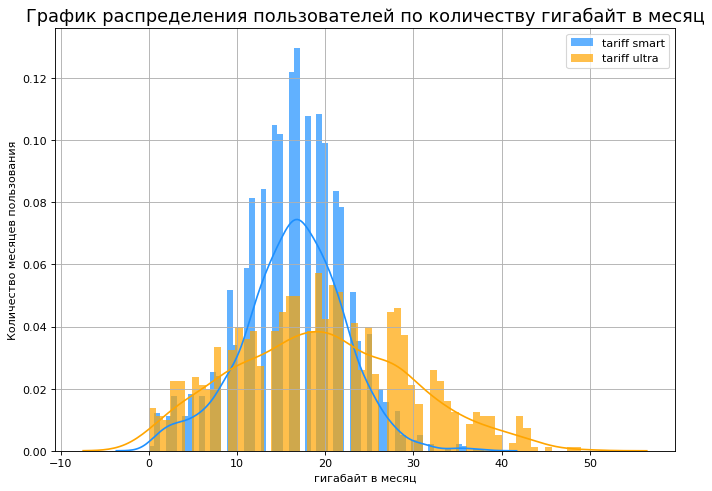

In [213]:
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(users_merge.loc[users_merge['tariff'] == 'smart',"tariff_gb_used"], 
             color="dodgerblue", 
             label="tariff smart", 
             hist_kws={'alpha':.7}, bins=60) 

sns.distplot(users_merge.loc[users_merge['tariff'] == 'ultra',"tariff_gb_used"], 
             color="orange", 
             label="tariff ultra", 
             hist_kws={'alpha':.7}, bins=60)

plt.title('График распределения пользователей по количеству гигабайт в месяц', fontsize=16)
plt.xlabel('гигабайт в месяц')
plt.ylabel('Количество месяцев пользования')
plt.legend()
plt.grid(True)
plt.show()

На тарифе Smart очевинет частый перерасход лимитного трафика в 15Гб.

### Минуты Сообщения и Интернет трафик в разрезе трафиов но с учетом в столице и не в столице

Для начала добавим столбец с пометкой из Москвы ли пользователь.

In [214]:
users['is_capital'] = users['city'].apply(lambda x: True if x=='Москва' else False)

In [215]:
users_merge = pd.merge(users_merge, users[['user_id','is_capital']], on='user_id', how='outer')

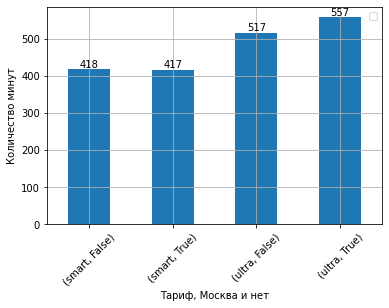

In [216]:
df = pd.pivot_table(users_merge, index=['tariff','is_capital'], values='sum_tariff_minuts', aggfunc='mean')
df \
    .round(0) \
    .plot(rot=45,kind='bar',grid=True)
    
plt.legend('')
plt.xlabel('Тариф, Москва и нет')
plt.ylabel('Количество минут')

for i, val in enumerate(df.values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom')

plt.show()

На тарифе Smart нет разницы где проживает абонент.
На тарифе Ultra  в целом разговаривают больше - но в Москве это заметнее.

In [217]:
pd.pivot_table(users_merge, index=['tariff','is_capital'], values='messages', aggfunc='mean').round(0)

messages
tariff is_capital          
smart  False           35.0
       True            28.0
ultra  False           48.0
       True            55.0

Я считал что СМС уже отжили своё, но оказывается что нет. На тарифе Smart в регионах смсят чаще, но на тарифе Ultra в Москве это делаю больше. 

In [218]:
pd.pivot_table(users_merge, index=['tariff','is_capital'], values='mb_used', aggfunc='mean').round(0)

mb_used
tariff is_capital         
smart  False       16248.0
       True        16018.0
ultra  False       18926.0
       True        21302.0

На тарифе Smart получается что в среднем выходят за лимитные 15 Гб, не зависимо от региона.
На тарифе Ultra сидят в интернете на много больше - потому что там лимит больше - но ограничения в 30 Гб в среднем не достигают. 

### Выручка

Посмотрим как ведет себя выручка в срднем с абонента за месяц

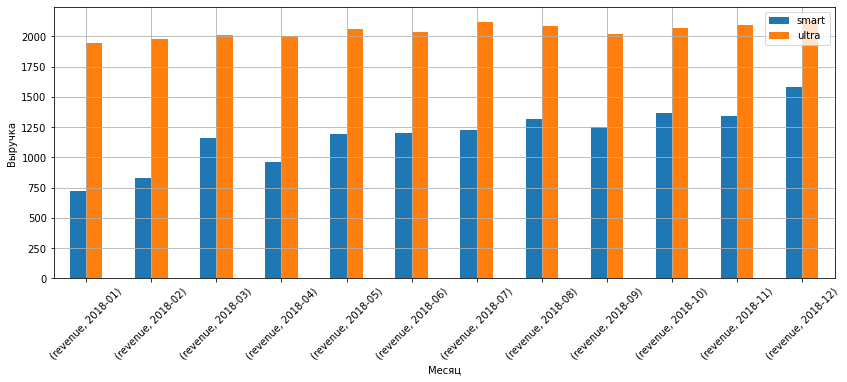

In [219]:
df = pd.pivot_table(users_merge, index=['tariff','month'], values='revenue', aggfunc= 'mean').unstack().T

df.round(0).plot(rot=45,kind='bar',grid=True,figsize=(14, 5))
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('Выручка')

plt.show()

Вау - а на тарифе Smart выручка даже очень хорошо растет.

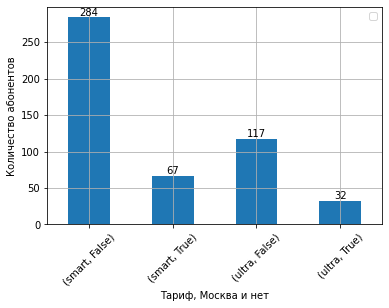

In [220]:
df = pd.pivot_table(users, index=['tariff','is_capital'], values='user_id', aggfunc='count').round(0)
df \
    .round(0) \
    .plot(rot=45,kind='bar',grid=True)
    
plt.legend('')
plt.xlabel('Тариф, Москва и нет')
plt.ylabel('Количество абонентов')

for i, val in enumerate(df.values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom')

plt.show()

Не зависимо от региона, почти в 2 раза больше абонентов отдает предпочтение тарифу Smart

## Проверка гипотез

Для проверки гипотиз буду использовать Критерий Стьюдента (t-критерий). Он позволяет найти вероятность того, что оба средних значения в выборке относятся к одной и той же совокупности.

### средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Проверим гипотезу : средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
Это похоже на гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. и нужно бы применить метод ttest_ind.
Но посмотрим на некоторые характеристики выборок.

In [221]:
pd.pivot_table(users_merge, index='tariff', values='revenue',aggfunc=['mean',var1,np.std])

,mean,var1,std
,revenue,revenue,revenue
tariff,,,
smart,1289.973531,669785.708006,818.404367
ultra,2070.396745,141775.504348,376.530881


In [222]:
#users['tariff'].value_counts()
users['tariff'].value_counts(normalize=True)

smart    0.702
ultra    0.298
Name: tariff, dtype: float64

Общего между выборками совсем нет.

Меньше трети абонентов представлены на тарифе Ultra. Выборки не равны по количеству значений...
Поэтому считаю что лучше попробовать проверить двухстороннюю гипотезу о равентве среднего значения (выборки которая меньше) определенному значению (среднему выборки которая больше).<br>
Сформулирую гипотезы: H0 Среднее тарифа Ultra равно значению 1289(среднее тарифа Smart). H1 - Среднее тарифа Ultra отличается от значения 1289

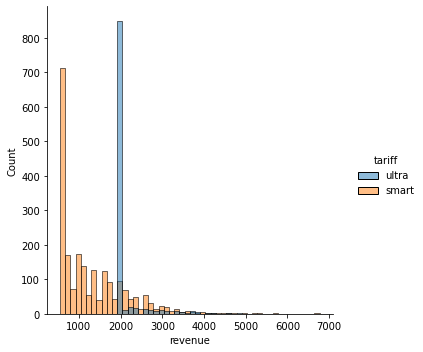

In [223]:
sns.displot(data=users_merge, x='revenue',hue='tariff',bins=50)

In [224]:
interested_value = 1289
alpha = .05 # критический уровень статистической значимости

results = st.ttest_1samp(
    users_merge[users_merge['tariff'] == 'ultra']['revenue'],
    interested_value)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  nan
Не получилось отвергнуть нулевую гипотезу


p-значение практически равно нулю - это означает что, при верной нулевой гипотезе, вероятность случайно получить значение 1289 исчезающе мала - то есть получить такую или еще более выраженную разницу между средним значением прибыли на Тарифе Ultra и интересующим нас значением 1289 практически не возможно (получить из выборки значение 1289 случайным образом невозможно) - следовательно нулевая гипотеза не состоятельна и её можно отвергнуть.

_____________________________________________________

На всякий случай проведу проверку гипотезы о равности среднего двух совокупностей. <br>
Дисперсии у совокупностей разные (при вызове метода ttest_ind нам надо указать equal_var = False)

Рассмотрим три аспекта, которые надо проверить, чтобы понять, можно ли применять t-тест:
- Генеральные совокупности не должны зависеть друг от друга. - так и есть.
- Выборочные средние должны быть нормально распределены. - Выборка всего одна, и как её среднее распределена для разных выборок этого размера из генеральной совокупности - мы не видим. Но благодаря ЦПТ, если размер выборки составляет хотя бы несколько десятков значений(у нас 149 и 351), выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены нормально вокруг истинного среднего этой совокупности.
- Дисперсии рассматриваемых генеральных совокупностей должны быть равны. При этом если выборки достаточно велики (30 и больше значений) и равны по размеру между собой. Симуляции, проведённые учёными, показывают, что даже если дисперсии на самом деле не равны, то тест редко ошибается. (из-за этого пункта я решил сначало провести тест методом ttest_1samp)

Озвучим нулевую гипотезу H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна, и альтернативную гипотезу H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна.

In [94]:
users_merge

,user_id,month,calls_count,sum_tariff_minuts,messages,mb_used,gb_used,tariff_gb_used,tariff,revenue,is_capital
0,1000,2018-05,17.0,159.0,22.0,2253.49,2.20,3.0,ultra,1950.0,False
1,1000,2018-06,28.0,172.0,60.0,23233.77,22.69,23.0,ultra,1950.0,False
2,1000,2018-07,41.0,340.0,75.0,14003.64,13.68,14.0,ultra,1950.0,False
3,1000,2018-08,42.0,408.0,81.0,14055.93,13.73,14.0,ultra,1950.0,False
4,1000,2018-09,46.0,466.0,57.0,14568.91,14.23,15.0,ultra,1950.0,False
...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,2018-09,8.0,70.0,11.0,1845.75,1.80,2.0,smart,550.0,False
3212,1499,2018-11,62.0,612.0,59.0,17963.31,17.54,18.0,smart,1513.0,False
3213,1499,2018-10,44.0,449.0,48.0,17788.51,17.37,18.0,smart,1150.0,False
3214,1128,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [93]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    users_merge[users_merge['tariff'] == 'smart']['revenue'], 
    users_merge[users_merge['tariff'] == 'ultra']['revenue'],
    equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  nan
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value очень мало - что говорит о не состаятельности нулевой гепотизы - то есть  шанс получить значимое различие между средними выборок при нулевой гепотезе очень мал. Значит можем её отвергнуть.

### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Проверим гипотезу : средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Рассмотрим характеристики выборок

In [ ]:
users['is_capital'].value_counts()

в датасете Users пользователей из Москвы всего 99.

In [ ]:
# users_merge['is_capital'].value_counts(normalize=True)
users_merge['is_capital'].value_counts()

В таблице с разбивкой по месяцам всего 611 значений от пользователей из Москвы.

In [ ]:
pd.pivot_table(users_merge,index='is_capital',values='revenue',aggfunc=['mean',var1,np.std])

Средние выборок почти равны. Дисперсия сопоставима, сигма различается не на много.

Примем нулевую гипотезу H0 - средняя выручка пользователей из Москвы и из других регионов равна, и альтернативную гипотезу H1 - средняя выручка пользователей из Москвы и из других регионов не равна.

In [ ]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    users_merge[users_merge['is_capital'] == True]['revenue'], 
    users_merge[users_merge['is_capital'] == False]['revenue'],
    equal_var=True) # True - так как дисперсии различаются не сильно

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно чуть больше 5%, хотя средние начение и неодинаковы. Это большая вероятность, чтобы делать вывод о значимом различии между средними.
Это означает что мы не можем отвергнуть нулевую гипотезу так как велик шанс случайно получить существующую разницу между средними (1546.7 - 1524.7) при таких выборках. Получается разницы между выручкой от пользователей из Москвы и других городов незначительна. 

In [226]:
def hypo_test(data1,data2,differ):
    alpha = .05 # критический уровень статистической значимости
    results = st.ttest_ind(data1,data2,equal_var=differ) # True - так как дисперсии различаются не сильно
    
    print('p-значение: ', results.pvalue)

    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
    
data1  = users_merge[users_merge['is_capital'] == True]['revenue']
data2  = users_merge[users_merge['is_capital'] == False]['revenue']

hypo_test(data1,data2,False)



p-значение:  nan
Не получилось отвергнуть нулевую гипотезу


## Итоговый вывод

Данные предоставленны в отличном состоянии - требовалось предобработки по минимому.
На основе имеющихся данных было не сложно расчитать дополнительные столбцы и выручку.
Анализ данных показал что выручка растет за счет пользователей тарифом Smart - к нему подключаются чаще и чаще по нему происходит перелемит.

Гипотеза о том что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются - подтвердилась!
Гипотеза о том что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов - не подтвердилась!

В случае если на рынке есть несколько операторов с различными тарифными планами - рекомендовал бы оператору, для удержания абонентов, закрыть слишком большой разрыв в абон плате между тарифами - создать промежуточный тариф.
Необходимость в нем созреет когда станет очевидет предстоящий отток абонентов, которые устанут переплачивать за перелимиты но подключаться к более дорогому Ultra не планируют. 

Еще много инсайтов можно попробовать покапать в этих данных - например сезон спада или подъёма потребления услуг - для предугадывания нагрузки на сеть или реализаций каких нибудь акций и рекламных компаний.